In [2]:
import numpy as np
import time
import itertools as it

import matplotlib.pylab as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
import pickle

import pandas as pd
import scipy.interpolate
import os, sys
import scipy
from scipy import interpolate, integrate
from scipy.integrate import ode, solve_ivp, odeint

# import corner
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
import astropy.constants as const

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

from palettable.cubehelix import cubehelix3_16
col = cubehelix3_16.hex_colors

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)

sys.path.append('../')
import bubbles

In [3]:
%load_ext autoreload
%autoreload 2

# Bubble size

In [4]:
Ndot_ion     = bubbles.Muv_to_Nion(Muv=-22, z=7)
z_s          = 7 # Redshift source observed
t_age        = 1e8 * u.yr
fesc_test    = 1.
C_test       = 3.
alpha_s_test = -2.

# What redshift did source form?
t_now       = Planck15.age(z=z_s)
t_source_on = t_now - t_age
z_source_on = z_at_value(Planck15.age, t_source_on)

# Find full ionized bubble
R3 = odeint(bubbles.dRion3_dt, y0=0., t=[0, t_age.value],
            args=(z_source_on, fesc_test*Ndot_ion, C_test), tfirst=True)

R_ion = R3.T[0][1]**(1/3.) * u.Mpc    

# Optically thin region
R_alpha = bubbles.R_optically_thin(z=z_s, Ndot_ion=Ndot_ion, 
                                   reccase='B', alpha_s=alpha_s_test, fesc=fesc_test, 
                                   C=C_test, T=1e4*u.K) 

In [5]:
print(f'R_alpha={R_alpha.value:.2f} Mpc, R_ion={R_ion.value:.2f} Mpc')

z_ion   = bubbles.z_at_proper_distance(R_ion, z_1=z_s)
z_alpha = bubbles.z_at_proper_distance(R_alpha, z_1=z_s)
print(f'z_s={z_s}, z_alpha={z_alpha.value:.3f}, z_ion={z_ion.value:.3f}')

R_alpha=0.28 Mpc, R_ion=3.57 Mpc
z_s=7, z_alpha=6.994, z_ion=6.919


# Sources

In [6]:
wave_em = np.linspace(1200, 1240., 2000) * u.Angstrom

## A - center of bubble

In [7]:
# inside bubble
tau_HII_A = bubbles.optical_depth(wave_em, z_min=z_ion, z_max=z_s, 
                                  z_s=z_s, z_bubble_center=z_s,
                                  inside_HII=True, C_HII=C_test, T=1.e4*u.K, Ndot_ion=Ndot_ion)

# in IGM
tau_IGM_A = bubbles.optical_depth(wave_em, z_min=6., z_max=z_ion,
                                  z_s=z_s, z_bubble_center=z_s,
                                  inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

tau_total_A = tau_IGM_A + tau_HII_A

/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## B - near R_alpha

In [15]:
print(z_alpha, z_s)
z_s_B = z_alpha*(1+0.0001)
print(z_s_B)

# inside bubble
tau_HII_B = bubbles.optical_depth(wave_em, z_min=z_ion, z_max=z_s_B, 
                                  z_s=z_s_B, z_bubble_center=z_s,
                                  inside_HII=True, C_HII=C_test, T=1.e4*u.K, Ndot_ion=Ndot_ion)

# in IGM
tau_IGM_B = bubbles.optical_depth(wave_em, z_min=6., z_max=z_ion,
                                  z_s=z_s_B, z_bubble_center=z_s,
                                  inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

tau_total_B = tau_IGM_B + tau_HII_B

6.993679586944887 7
6.994378954903581


## C - outside R_alpha

In [16]:
z_s_C = 0.5*(z_alpha+z_ion)
print(z_s_C)
print(z_alpha, z_ion)

# inside bubble
tau_HII_C = bubbles.optical_depth(wave_em, z_min=z_ion, z_max=z_s_C, 
                                  z_s=z_s_C, z_bubble_center=z_s,
                                  inside_HII=True, C_HII=C_test, T=1.e4*u.K, Ndot_ion=Ndot_ion)

# in IGM
tau_IGM_C = bubbles.optical_depth(wave_em, z_min=6., z_max=z_ion, 
                                  z_s=z_s_C, z_bubble_center=z_s,
                                  inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

tau_total_C = tau_IGM_C + tau_HII_C

6.956178698990897
6.993679586944887 6.918677811036907


## D - outside R_ion

In [17]:
z_s_D = z_ion - 0.1
print(z_s_D)
print(z_alpha, z_ion)

# in IGM
tau_IGM_D = bubbles.optical_depth(wave_em, z_min=6., z_max=z_s_D, 
                                  z_s=z_s_D, z_bubble_center=z_s,
                                  inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

tau_total_D = tau_IGM_D

6.818677811036907
6.993679586944887 6.918677811036907


# Plot transmission

In [11]:
DV_tab = bubbles.wave_to_DV(wave_em)
DV = 200

line = bubbles.lineshape_doublepeak(v=DV_tab.value, vcenter=DV)
line/= np.max(line)

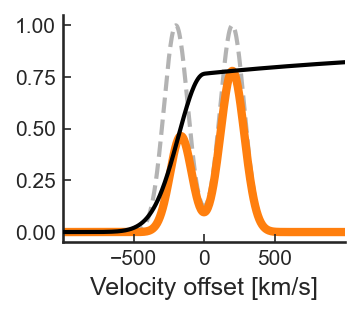

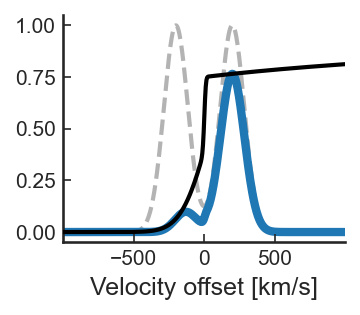

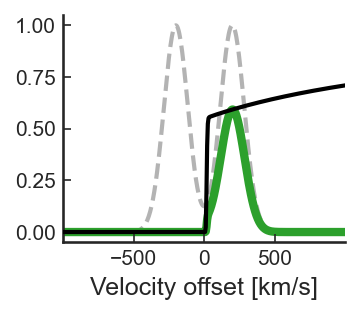

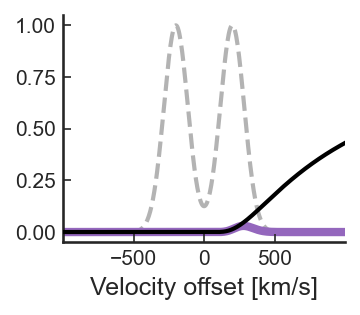

In [129]:
sources = {'A':tau_total_A, 'B':tau_total_B, 'C':tau_total_C, 'D':tau_total_D}
vlim = 1000
cols = ['tab:orange', 'tab:blue', 'tab:green', 'tab:purple']

for i, s in enumerate(sources):

    fig, ax_DV = plt.subplots(1,1, figsize=(2.5,2.2))
#     ax_wave = ax_DV.twiny()

    ax_DV.plot(DV_tab, line, c='0.7', ls='dashed', lw=2)

#     ax_wave.plot(wave_em, np.exp(-sources[s]), lw=0)
    ln = ax_DV.plot(DV_tab, np.exp(-sources[s]), c='k', alpha=1, lw=2, zorder=10)
    ax_DV.plot(DV_tab, line*np.exp(-sources[s]), lw=4, c=cols[i])#, label=f'{s}')

    ax_DV.set_xlim(-vlim, vlim)
#     ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

#     ax_DV.set_ylabel(r'Ly$\alpha$ transmission')
#     ax_wave.set_xlabel(r'Wavelength [$\mathrm{A}$]')
    ax_DV.set_xlabel('Velocity offset [km/s]')
    
    if i==0:
        ISM_line = mlines.Line2D([], [], c='0.7', ls='dashed', lw=2, label='ISM')
        IGM_line = mlines.Line2D([], [], c='0.7', lw=2, label='IGM transmission')
        obs_line = mlines.Line2D([], [], c='k', lw=4, label='observed')
#         plt.legend(handles=[ISM_line, IGM_line, obs_line], loc='upper left')

    ax_DV.spines['top'].set_visible(False)
    ax_DV.spines['right'].set_visible(False)
    ax_DV.yaxis.set_ticks_position('left')
    ax_DV.xaxis.set_ticks_position('bottom')
    
    ax_DV.minorticks_off()
    ax_DV.set_xticks([-500, 0, 500])

    plt.tight_layout()
    plt.savefig('../figs/cartoon/transmission_%s.pdf' % s, bbox_inches='tight')

# Check for sharp blue

In [21]:
z_s_test = z_alpha #0.5*(z_alpha+z_ion)
z_s_test = z_alpha*(1+0.0001)

print(z_s_test)
print(z_alpha, z_ion)

# inside bubble
tau_HII_test = bubbles.optical_depth(wave_em, z_min=z_ion, z_max=z_s_test, 
                                  z_s=z_s_test, z_bubble_center=z_s,
                                  inside_HII=True, C_HII=C_test, T=1.e4*u.K, Ndot_ion=Ndot_ion)

# in IGM
tau_IGM_test = bubbles.optical_depth(wave_em, z_min=6., z_max=z_ion, 
                                  z_s=z_s_test, z_bubble_center=z_s,
                                  inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

tau_total_test = tau_IGM_test + tau_HII_test

6.994378954903581
6.993679586944887 6.918677811036907


Text(0, 0.5, 'Transmission')

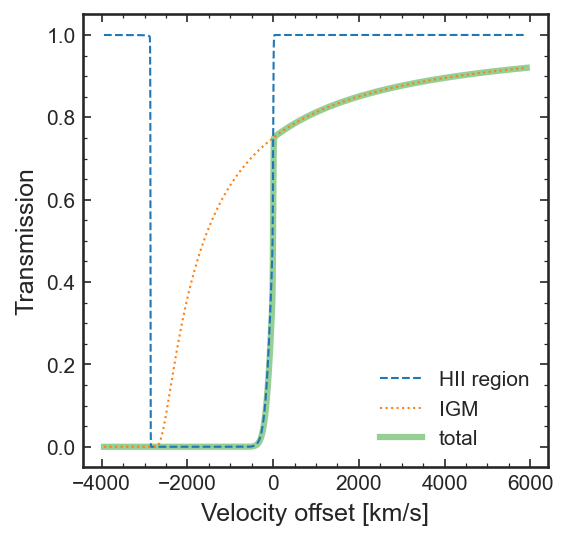

In [24]:
plt.plot(DV_tab, np.exp(-tau_HII_test), lw=1, ls='dashed', label='HII region')
plt.plot(DV_tab, np.exp(-tau_IGM_test), lw=1, ls='dotted',label='IGM')
plt.plot(DV_tab, np.exp(-tau_total_test), label='total', zorder=0, alpha=0.5, lw=3)

plt.legend()
plt.xlabel('Velocity offset [km/s]')
plt.ylabel('Transmission')



In [195]:
z_s_test = z_alpha #0.5*(z_alpha+z_ion)
z_s_test = z_alpha*(1+0.0001)

xHI  = [1e-7, 1e-4]
Rion = [0.5*u.Mpc, 10*u.Mpc]
zion_test = [bubbles.z_at_proper_distance(R, z_1=z_s) for R in Rion]
r_slope = [2., 0.]
print(z_s_test, z_alpha, zion_test)

tau_HII_1_test = bubbles.optical_depth_grid(wave_em, T=1e4*u.K, z_min=zion_test[0], z_max=z_s_test, 
                                  z_s=z_s_test, z_bubble_center=z_s,
                                  inside_HII=True, C_HII=1., 
                                  xHI_01=xHI[0], R_ion=Rion[0],
                                  r_slope=r_slope[0])

tau_HII_2_test = bubbles.optical_depth_grid(wave_em, T=1e4*u.K, z_min=zion_test[1], z_max=zion_test[0], 
# tau_HII_2_test = bubbles.optical_depth_grid(wave_em, T=1e4*u.K, z_min=6., z_max=zion_test[0], 
                                  z_s=z_s_test, z_bubble_center=z_s,
                                  inside_HII=True, C_HII=1., 
                                  xHI_01=xHI[1], R_ion=Rion[1],
                                  r_slope=r_slope[1])

# in IGM
tau_IGM_test = bubbles.optical_depth(wave_em, z_min=6., z_max=zion2_test, 
                                  z_s=z_s_test, z_bubble_center=z_s,
                                  inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

tau_total_test = tau_HII_1_test + tau_HII_2_test + tau_IGM_test

6.994378954903581 6.993679586944887 [<Quantity 6.98859678>, <Quantity 6.77193552>]


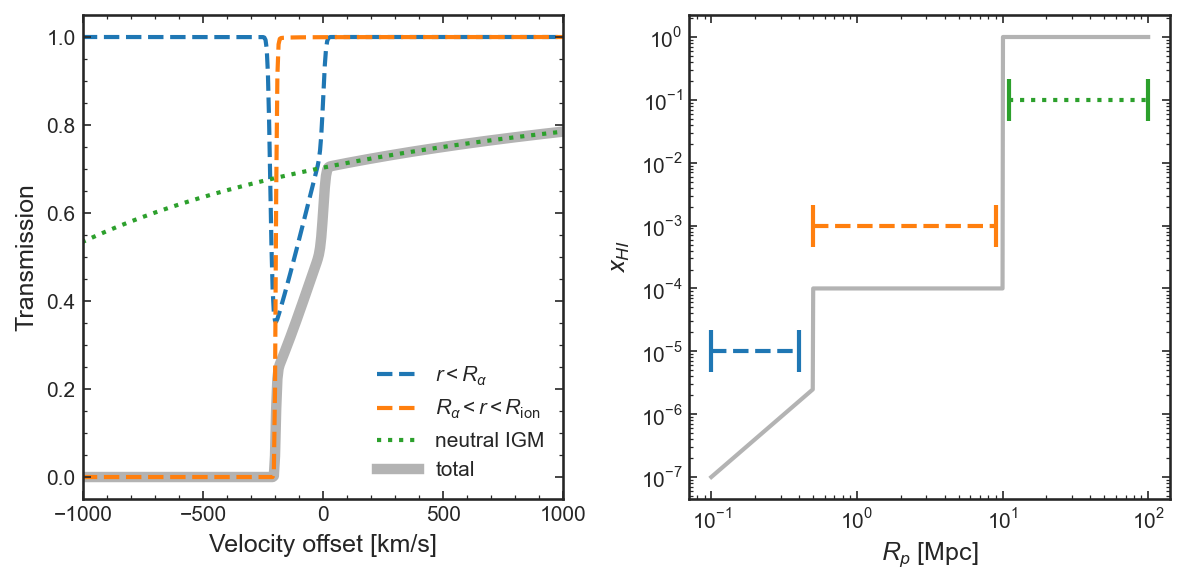

In [196]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

# Optical depth
ax[0].plot(DV_tab, np.exp(-tau_HII_1_test), lw=2, ls='dashed', label=r'$r < R_\alpha$')
ax[0].plot(DV_tab, np.exp(-tau_HII_2_test), lw=2, ls='dashed', label=r'$R_\alpha < r < R_\mathrm{ion}$')
ax[0].plot(DV_tab, np.exp(-tau_IGM_test),   lw=2, ls='dotted',label='neutral IGM')
ax[0].plot(DV_tab, np.exp(-tau_total_test), lw=5, label='total', zorder=0, c='0.7')

ax[0].legend()
ax[0].set_xlabel('Velocity offset [km/s]')
ax[0].set_ylabel('Transmission')
# ax[0].set_ylabel('Optical depth, $\tau$')
ax[0].set_xlim(-1000, 1000)

# Bubble
r_p = np.logspace(-1, 2, 1000)*u.Mpc
xHI_tab_all = np.zeros(len(r_p))
for i in range(2):
    xHI_tab = bubbles.xHI_approx(xHI[i], r_p, Rion[i], r_slope=r_slope[i]) 
    if i == 0:
        xHI_tab_all[r_p <= Rion[0]] = xHI_tab[r_p <= Rion[0]]
    if i == 1:
        xHI_tab_all[r_p > Rion[0]] = xHI_tab[r_p > Rion[0]]

#     ax[1].axvline(Rion[i], ls='dashed')
    
ax[1].plot([0.1, Rion[0].value-0.1], [1e-5, 1e-5], '|', ms=20, mew=2, zorder=10, ls='dashed')
ax[1].plot([Rion[0].value, Rion[1].value-1], [1e-3, 1e-3], '|', ms=20, mew=2, zorder=10, ls='dashed')
ax[1].plot([Rion[1].value+1, 100], [1e-1, 1e-1], '|', ms=20, mew=2, zorder=10, ls='dotted')
ax[1].loglog(r_p, xHI_tab_all, c='0.7')

ax[1].set_xlabel('$R_p$ [Mpc]')
ax[1].set_ylabel('$x_{HI}$')

plt.tight_layout()